In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import scipy as scp

In [3]:
"""
read opsin data
(excel file)
"""
filepath = '../data/all_cone_recordings/'
filename = 'LED and opsin wavelength.xlsx'
data = pd.read_excel (filepath+filename, header =0 )#[::-1]

opsin_df = data


"""
read LED data
(excel file)
"""
filepath = '../data/all_cone_recordings/'
filename = 'LED wavelength.xlsx'
data = pd.read_excel (filepath+filename, header =0 )#[::-1]

led_df = data


"""
read control data
"""

filepath = '../data/all_cone_recordings/'
filename = 'R-Cone recordings - control_merged.xlsx'
data_R = pd.read_excel (filepath+filename, header=0)

filename = 'G-Cone recordings - control_merged.xlsx'
data_G = pd.read_excel (filepath+filename, header =0 )


filename = 'B-Cone recordings - control_merged.xlsx'
data_B = pd.read_excel (filepath+filename, header =0 )

filename = 'U-Cone recordings - control_merged.xlsx'
data_U = pd.read_excel (filepath+filename, header =0 )

# merge dfs
control_df = pd.concat([data_R,data_G,data_B, data_U], ignore_index=True)


"""
read hc_block data
"""

filepath = '../data/all_cone_recordings/'
filename = 'R-Cone recordings - HCblock.xlsx'
data_R = pd.read_excel (filepath+filename, header =0 )

filename = 'G-Cone recordings - HCblock.xlsx'
data_G = pd.read_excel (filepath+filename, header =0 )


filename = 'B-Cone recordings - HCblock.xlsx'
data_B = pd.read_excel (filepath+filename, header =0 )

filename = 'U-Cone recordings - HCblock.xlsx'
data_U = pd.read_excel (filepath+filename, header =0 )


# merge dfs
hc_block_df = pd.concat([data_R,data_G,data_B, data_U], ignore_index=True)



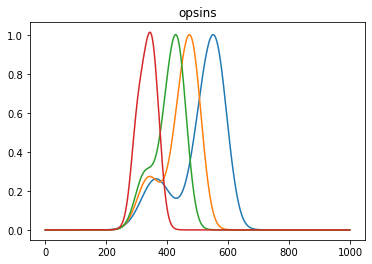

In [7]:
"""
plot opsins
"""
plt.title("opsins")
for cone in ['R','G','B','U']:
    plt.plot(opsin_df['wavelength'],opsin_df[cone] )

###  fit linear transformation of opsin to HC-block-data

In [11]:
def optimizing_fun(params, x, data, return_fit=False):
    """
    applies linear transformation on log(x+c) and normalizes to have max 1
    f_(x) = a*log(x+c_log)+b, f = f_/max(f_)
    returns: mse(f(x),data), optional f
    """
    a,b,c_log=params
    fit = a*np.log(x+c_log)+b
    fit = fit/np.max(fit)
    mse = np.mean((fit-data)**2)
    if return_fit:
        return fit, mse
    else:
        return mse
    
    
def get_data(cone_type, hc_block_df, led_df, opsin_df):
    """
    return: normalized mean of experimental hc_block traces for specified cone type (interpolated), 
            opsin for specific cone_type,
            corresponding wavelength
    """
    #compute mean control traces and interpolate to opsin wavelength
    wavelength = led_df[:13]['Wavelength'].values[::-1]
    data = hc_block_df[hc_block_df['cone_type']==cone_type].mean(axis=0).values[::-1]
    data = data/np.max(data)
    
    opsin = opsin_df[(opsin_df['wavelength']>=360)&(opsin_df['wavelength']<=655) ][cone_type].values
    
    wavelength_interp = np.arange(360,656)
  
    data_interp = scp.interpolate.interp1d(wavelength,data)(wavelength_interp) 
    
    return data_interp, opsin, wavelength_interp

In [9]:
"""
optimize parameters for all cones
"""

res_all = []
fit_all = []
mse_all = []
data = []



for cone_type in ['R', 'G', 'B','U']:
    
    # get data 
    data1, opsin,wavelength_interp = get_data(cone_type, hc_block_df, led_df, opsin_df)
    data.append(data1)

   
    # minimize mse
    res = scp.optimize.minimize(optimizing_fun, x0=[0.5,2,0.1], 
                                args=(opsin, data1),
                               bounds=((0,10),(0,10),(0,10)))
    
    # extract results
    fit, mse = optimizing_fun(res.x,opsin, data1, return_fit=True )
    res_all.append(res)
    fit_all.append(fit)
    mse_all.append(mse)

"""
put into dataframe
"""
for i, cone_type in enumerate(['R', 'G', 'B','U']):

    opsin_df[cone_type+'_fitted_opsin'] =  np.hstack([np.nan*np.zeros(360), fit_all[i],np.nan*np.zeros(345)])
    
    opsin_df[cone_type+'_hc_block_norm_mean'] =  np.hstack([np.nan*np.zeros(360), data[i],np.nan*np.zeros(345)])

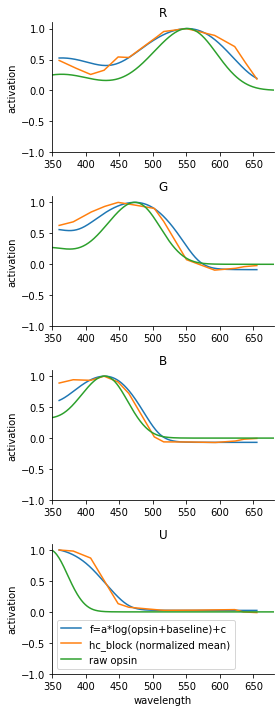

In [25]:
"""
show the fits
"""
save = False
labels=['R', 'G', 'B','U']
plt.figure(1,figsize=(4,10))
for i,fit in enumerate(fit_all):
    plt.subplot(4,1,i+1)
    plt.title(labels[i])
    #plt.text(350,-0.5, 'a,c, baseline='+str(res_all[i].x))
    plt.plot(wavelength_interp, fit, label= 'f=a*log(opsin+baseline)+c')
    plt.plot(wavelength_interp,data[i], label= 'hc_block (normalized mean)')
    
    if i==0:
        plt.plot(opsin_df.wavelength,opsin_df.R, label="raw opsin")
    elif i==1:
        plt.plot(opsin_df.wavelength,opsin_df.G, label="raw opsin")
    elif i==2:
        plt.plot(opsin_df.wavelength,opsin_df.B, label="raw opsin")      
    elif i==3:
        plt.plot(opsin_df.wavelength,opsin_df.U, label="raw opsin")

    plt.xlim(350,680)
    #plt.axhline(0,ls=':')
    plt.ylim(-1,1.1)
    plt.ylabel("activation")
plt.xlabel('wavelength')
plt.tight_layout()
plt.legend()
sns.despine()


if save:
    filepath = '/gpfs01/berens/user/cschroeder/Documents/Biophysical Models/Cone_HC_interaction/R_analysis/plots/opsin/'
    filename = 'log_opsin_fitted_to_HCblock'
    plt.savefig(filepath+filename+'.png', dpi=600, format='png',  bbox_inches='tight')


In [12]:
res_all

[      fun: 0.008173316552502323
  hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
       jac: array([-3.76088052e-07,  2.02789176e-07,  1.32862471e-06])
   message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
      nfev: 64
       nit: 13
      njev: 16
    status: 0
   success: True
         x: array([1.00933087, 1.88329094, 0.19047147]),
       fun: 0.010264381816972708
  hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
       jac: array([-2.04732064e-06,  7.57033330e-07, -1.10328413e-06])
   message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
      nfev: 52
       nit: 10
      njev: 13
    status: 0
   success: True
         x: array([0.71443778, 1.94339294, 0.05182517]),
       fun: 0.007643412263686352
  hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
       jac: array([-1.09131453e-06,  5.32907055e-07,  3.65775119e-06])
   message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
      nfev: 60
       nit: 12
      njev: 15
    status: 0


# Now the other way round: fit hc_block to opsin

### Model:
f(hc_block) = fitted_opsin

with f(x) = np.exp(a*x)+b

fit a,b,c to opsin

By this we can pass the uncertainty of the recordings through f to get intervals of the data distribution.

In [29]:
def optimizing_fun_2(params, x, data, return_fit=False):
    """
    applies linear transformation on exp(x+b) and normalizes to have max 1
    f_(x) = a*exp(b*x)+c, f = f_/max(f_)
    returns: mse(f(x),data), optional f
    """
    a,b,c=params
    fit = a*np.exp(b*x)+c
    fit = fit/np.max(fit)
    mse = np.mean((fit-data)**2)
    if return_fit:
        return fit, mse
    else:
        return mse
    
    
def get_data(cone_type, hc_block_df, led_df, opsin_df):
    """
    return: normalized mean of experimental hc_block traces for specified cone type, opsin for cone_type
    """
    #compute mean control traces and interpolate to opsin wavelength
    wavelength = led_df[:13]['Wavelength'].values[::-1]
    
    #data = hc_block_df[hc_block_df['cone_type']==cone_type].mean(axis=0).values[::-1]
    
    data = np.percentile(hc_block_df[hc_block_df['cone_type']==cone_type].values[:,:13].astype(float),q=50,axis=0)[::-1]

    #data = data/np.max(data)
    
    opsin = opsin_df[(opsin_df['wavelength']>=360)&(opsin_df['wavelength']<=655) ][cone_type].values
    
    opsin= opsin/ np.max(opsin)

    
    wavelength_interp = np.arange(360,656)
  
    #data_interp = scp.interpolate.interp1d(wavelength,data)(wavelength_interp) 
    
    opsin_downsampled = scp.interpolate.interp1d(wavelength_interp,opsin)(wavelength) 

    
    return data, opsin_downsampled, wavelength

In [30]:
"""
optimize parameters for all cones
"""

res_all = []
fit_all = []
mse_all = []
hc_block_all = []
opsin_all=[]


for cone_type in ['R', 'G', 'B','U']:
    
    # get data 
    hc_block, opsin, wavelength = get_data(cone_type, hc_block_df, led_df, opsin_df)
    hc_block_all.append(hc_block)
    opsin_all.append(opsin)

   
    # minimize mse
    res = scp.optimize.minimize(optimizing_fun_2, x0=[1,0.1,-1], #-5
                                args=(hc_block, opsin),
                               bounds=((0,100),(-100,100),(-100,100)))
    
    # extract results
    fit, mse = optimizing_fun_2(res.x, hc_block, opsin,return_fit=True )
    res_all.append(res)
    fit_all.append(fit)
    mse_all.append(mse)

"""
put into dataframe
"""
##for i, cone_type in enumerate(['R', 'G', 'B','U']):
#    opsin_df[cone_type+'_fitted_opsin'] =  np.hstack([np.nan*np.zeros(360), fit_all[i],np.nan*np.zeros(345)])   
#    opsin_df[cone_type+'_hc_block_norm_mean'] =  np.hstack([np.nan*np.zeros(360), data[i],np.nan*np.zeros(345)])

'\nput into dataframe\n'

In [31]:
res_all


[      fun: 0.003848348620902109
  hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
       jac: array([ 3.01000546e-06,  8.47603243e-06, -7.18565836e-07])
   message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
      nfev: 204
       nit: 31
      njev: 51
    status: 0
   success: True
         x: array([1.69735881, 3.89021067, 7.10899184]),
       fun: 0.014999860280976012
  hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
       jac: array([ 6.41847690e-09, -3.70866534e-06, -1.90819567e-09])
   message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
      nfev: 124
       nit: 23
      njev: 31
    status: 0
   success: True
         x: array([2.7290757 , 4.76135935, 8.62857712]),
       fun: 0.01785515627724549
  hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
       jac: array([ 8.27116158e-07,  1.26496037e-06, -3.57699983e-07])
   message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
      nfev: 140
       nit: 26
      njev: 35
    status: 

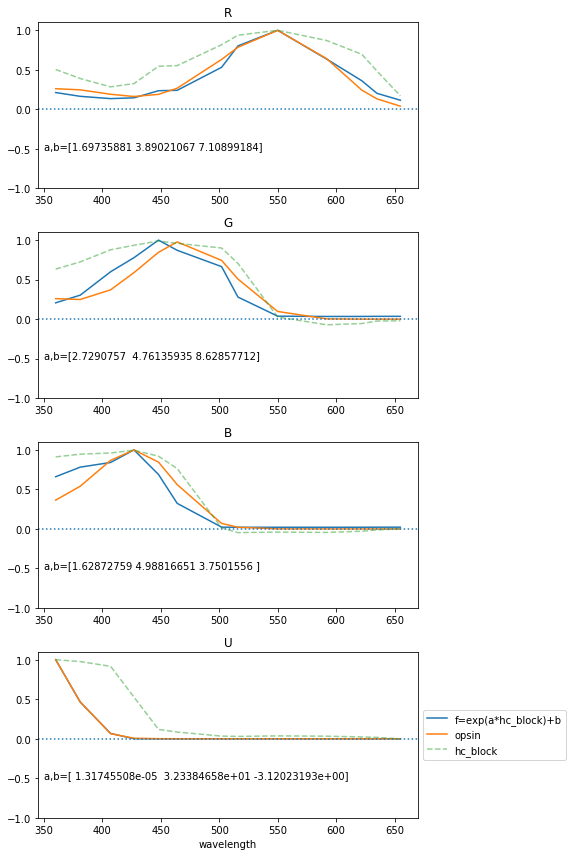

In [34]:
labels=['R', 'G', 'B','U']
plt.figure(1,figsize=(6,12))
for i,fit in enumerate(fit_all):
    plt.subplot(4,1,i+1)
    plt.title(labels[i])
    plt.text(350,-0.5, 'a,b='+str(res_all[i].x))
    plt.plot(wavelength, fit, label= 'f=exp(a*hc_block)+b')
    plt.plot(wavelength,opsin_all[i], label= 'opsin')
    plt.plot(wavelength,hc_block_all[i], label= 'hc_block',  ls='--', alpha=0.5)

    plt.axhline(0,ls=':')
    plt.ylim(-1,1.1)
plt.xlabel('wavelength')
plt.tight_layout()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

## calc confidence intervals

In [35]:
"""
compute percentiles
"""

fitted_opsins = [[] for _ in range(4)]
fitted_opsins_ps_1 = [[] for _ in range(4)]


for cone_nr in range(4):

    cone_type = labels[cone_nr]
    
    
    # choose all data of one cone
    hcs = hc_block_df[hc_block_df['cone_type']==cone_type].values[:,:13].astype(float)[::-1]
    
    # interate over these single recordings
    for i in range(hcs.shape[0]):
        hc_single = hcs[i]

        fit, _ = optimizing_fun_2(res_all[cone_nr].x, hc_single, opsin_all[cone_nr], return_fit=True)
        fitted_opsins[cone_nr].append(fit[::-1])
    fitted_opsins[cone_nr]=np.array(fitted_opsins[cone_nr])
    
    
    # compute percentiles
    qs= [25,50,75]
    for q in qs:
         fitted_opsins_ps_1[cone_nr].append(np.percentile(fitted_opsins[cone_nr],q=q,axis=0))

            
            
"""
get leds where opsin is not in 50% data distribution
"""

# get led wavelenghts
wls = led_df.Wavelength.values[::-1]

out_of_data = []

for cone_nr in range(4):
    mask = np.invert((np.array(opsin_all[cone_nr] >= fitted_opsins_ps_1[cone_nr][0]) &
    np.array(opsin_all[cone_nr] <= fitted_opsins_ps_1[cone_nr][2])))
    out_of_data.append(wls[mask])

In [36]:
hc_block_df.columns

Index(['LED1', 'LED2', 'LED3', 'LED4', 'LED5', 'LED6', 'LED7', 'LED8', 'LED9',
       'LED10', 'LED11', 'LED12', 'LED13', 'cone_type'],
      dtype='object')

In [37]:
hc_block_df

,LED1,LED2,LED3,LED4,LED5,LED6,LED7,LED8,LED9,LED10,LED11,LED12,LED13,cone_type
0,0.030183,0.438274,0.711003,0.974555,1.000000,0.970217,0.925988,0.644702,0.566018,0.343515,0.258453,0.443403,0.572394,R
1,0.175098,0.525547,0.779414,0.915361,1.000000,0.917134,0.849945,0.649026,0.627097,0.413564,0.286232,0.368587,0.616430,R
2,-0.008036,0.337817,0.639024,0.841187,1.000000,0.893505,0.834763,0.610067,0.544950,0.136997,0.201251,0.318654,0.307629,R
3,0.142861,0.648612,0.857873,0.974308,0.996759,1.000000,0.989203,0.701700,0.761916,0.461381,0.471046,0.481860,0.654313,R
4,0.205651,0.545267,0.726050,0.939351,0.967655,1.000000,0.894807,0.661667,0.648347,0.478031,0.529478,0.519824,0.720654,R
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
522,0.129744,0.267618,0.215336,0.042902,0.095832,-0.095660,0.010600,0.031407,0.032447,-0.030946,0.610824,0.675484,0.822138,U
523,-0.141135,0.053285,-0.085676,-0.089695,0.038728,-0.103610,-0.093205,0.113650,0.036638,0.765722,0.971021,0.905626,1.000000,U
524,0.060947,-0.008159,-0.017034,-0.423146,-0.294275,-0.356889,-0.167148,-0.456234,-0.432667,0.225974,0.557411,1.000000,0.876487,U
525,0.089411,0.017426,0.192703,-0.026877,0.092927,0.014139,0.387593,0.421772,0.247705,0.355610,0.497257,1.000000,0.876750,U


In [38]:
"""
put into datafram
"""
cone_nr = 0
cone_type = labels[cone_nr]

df = pd.DataFrame(columns=['LED1', 'LED2', 'LED3', 'LED4', 'LED5', 'LED6', 'LED7', 'LED8', 'LED9',
       'LED10', 'LED11', 'LED12', 'LED13'], data=fitted_opsins[cone_nr][:,::-1])
df['cone_type'] = cone_type

for cone_nr in [1,2,3]:
    cone_type = labels[cone_nr]
    print(cone_type)
    df1 = pd.DataFrame(columns=['LED1', 'LED2', 'LED3', 'LED4', 'LED5', 'LED6', 'LED7', 'LED8', 'LED9',
       'LED10', 'LED11', 'LED12', 'LED13'], data=fitted_opsins[cone_nr][:,::-1])
    df1['cone_type'] = cone_type
    df = df.append(df1)


"""
save fitted opsin curves
"""
filepath = '../data/all_cone_recordings/'

#df.to_csv(filepath+'opsin_fitted_v2.csv')

G
B
U


In [40]:
df

,LED1,LED2,LED3,LED4,LED5,LED6,LED7,LED8,LED9,LED10,LED11,LED12,LED13,cone_type
0,1.398672e-01,2.178990e-01,3.651694e-01,1.000000e+00,5.191571e-01,3.196957e-01,7.743162e-01,2.712017e-01,5.674313e-01,1.812682e-01,0.250269,0.302771,0.248514,R
1,1.809544e-01,6.410982e-01,5.596892e-01,7.363237e-01,1.000000e+00,6.139622e-01,4.184992e-01,2.984679e-01,4.077027e-01,2.617534e-01,0.301219,0.260095,0.449220,R
2,1.330693e-01,2.930536e-01,4.725285e-01,5.110924e-01,1.000000e+00,3.268057e-01,5.818608e-01,5.024811e-01,2.178000e-01,1.946475e-01,0.156015,0.166042,0.225638,R
3,1.015044e-01,1.881260e-01,2.350776e-01,1.000000e+00,3.772840e-01,4.165612e-01,4.120526e-01,3.609286e-01,3.630223e-01,1.238452e-01,0.135814,0.755852,0.474537,R
4,1.148897e-01,9.599564e-02,1.536006e-01,4.191565e-01,1.000000e+00,6.988154e-01,2.605846e-01,1.699565e-01,1.157922e-01,1.516293e-01,0.147148,0.156001,0.123210,R
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160,-2.384536e-09,-2.383623e-09,-2.381200e-09,-2.383173e-09,-2.384095e-09,-2.383971e-09,-2.383310e-09,-2.378128e-09,-2.239147e-09,8.221012e-07,0.214959,0.606344,1.000000,U
161,-2.138128e-09,-2.138128e-09,-2.138128e-09,-2.138126e-09,-2.138128e-09,-2.138129e-09,-2.138128e-09,-2.138127e-09,-2.138124e-09,-1.086283e-09,0.131934,0.290269,1.000000,U
162,-3.425446e-09,-3.424979e-09,-3.425414e-09,-3.425123e-09,-3.424987e-09,-3.425221e-09,-3.424244e-09,-3.423711e-09,-3.395622e-09,1.012350e-06,0.630764,0.729523,1.000000,U
163,-2.138128e-09,-2.138128e-09,-2.138128e-09,-2.138129e-09,-2.138128e-09,-2.138129e-09,-2.138129e-09,-2.138128e-09,-2.138122e-09,1.129282e-07,0.334308,0.879061,1.000000,U


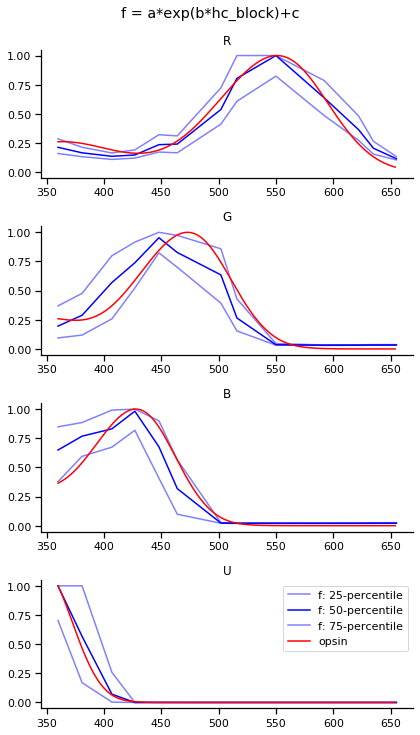

In [42]:
"""
final plot
"""

save = False

sns.set_context('notebook')
plt.figure(1, figsize=(6,10))
plt.suptitle('f = a*exp(b*hc_block)+c',y=1.02)

for cone_nr in range(4):
    plt.subplot(4,1,cone_nr+1)
    cone_type=labels[cone_nr]

    plt.title(cone_type)
    plt.plot(wavelength,fitted_opsins_ps_1[cone_nr][0], label='f: 25-percentile', color='blue', alpha=0.5)
    plt.plot(wavelength,fitted_opsins_ps_1[cone_nr][1], label='f: 50-percentile',color='blue', alpha=1)
    #plt.plot(wavelength,np.mean(fitted_opsins[cone_nr], axis=0), label='f: mean',color='green', alpha=1)
    plt.plot(wavelength,fitted_opsins_ps_1[cone_nr][2], label='f: 75-percentile',color='blue', alpha=0.5)
    #plt.plot(wavelength,opsin_all[cone_nr],'o', color='red',)
    #plt.plot(wavelength,fitted_means[cone_nr], label='mean', c='orange')
    temp = opsin_df[cone_type][360:655]
    temp=temp/np.max(temp)
    plt.plot(opsin_df['wavelength'][360:655],temp, 
             color='red', 
             ls='-', label='opsin')
    
    #plt.yscale('log')
    
    #plt.plot(wls,-np.ones(len(wls))*0.1,'o', color='green')
    #plt.plot(out_of_data[cone_nr],-np.ones(len(out_of_data[cone_nr]))*0.1,'o', color='red')
    plt.ylim(-0.05,1.05)
plt.legend()
plt.tight_layout()
sns.despine()

if save:
    filename = 'exp_HCblock_fitted_to_opsin'
    plt.savefig(filename+'.png', dpi=600, format='png',  bbox_inches='tight')


In [43]:
"""
put into datafram
"""
cone_nr = 0
cone_type = labels[cone_nr]

df = pd.DataFrame(columns=['led_wavelength'], data=out_of_data[cone_nr])
df['cone_type'] = cone_type

for cone_nr in [1,2,3]:
    cone_type = labels[cone_nr]
    print(cone_type)
    df1 = pd.DataFrame(columns=['led_wavelength'], data=out_of_data[cone_nr])
    df1['cone_type'] = cone_type

    df = df.append(df1)

"""
save to excel
"""
#df.to_excel('opsin_out_of_50p_data.xlsx')

G
B
U


'\nsave to excel\n'

In [46]:
wavelength

array([360, 381, 407, 427, 448, 464, 502, 516, 550, 592, 622, 635, 655])

In [45]:
"""
show out of data LEDs
"""
df

,led_wavelength,cone_type
0,381,R
1,407,R
2,622,R
3,635,R
4,655,R
0,464,G
1,516,G
2,550,G
3,592,G
4,622,G
